In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import regionmask
import regionmask.defined_regions as rm

%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import geopandas as gp
import cartopy
import cartopy.crs as ccrs
from tqdm import tqdm  # Fancy progress bars for our loops!

# Utility functions for stream-lining analysis
from utils import *

In [126]:
all_provinces = regionmask.defined_regions.natural_earth.states_provinces_10
all_provinces_names = [province if province is not None else 'None' for province in all_provinces.names]

## China

In [ ]:
df = load_jhu_df()
df.head()

['Xinjiang', 'Gansu', 'Yunnan', 'Heilongjiang', 'Jilin', 'Liaoning', 'Guangxi', 'Guangdong', 'Hainan', 'Fujian', 'Zhejiang', 'Shanghai', 'Jiangsu', 'Shandong', 'Hebei', 'Tianjin', 'Beijing', 'Sichuan', 'Chongqing', 'Guizhou', 'Hunan', 'Ningxia', 'Shaanxi', 'Qinghai', 'Shanxi', 'Jiangxi', 'Henan', 'Hubei', 'Anhui']


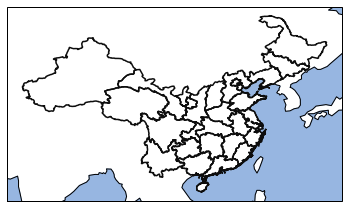

In [4]:
country = 'Mainland China'
cdf = df[df['Country/Region'] == country]

province_names = cdf['Province/State'].unique()
province_names = [province for province in all_provinces.names if province in province_names] # intersection of both data sets

provinces = all_provinces[province_names]
print(provinces.names)
provinces.plot(add_label=False);

In [5]:
ds = xr.open_dataset('../data/daily_spec_humidity_2020.nc')
provinces_mask = provinces.mask(ds['longitude'], ds['latitude'], wrap_lon=True)
provinces_ma = np.ma.masked_invalid(provinces_mask)

In [6]:
varnames = ['t2m', 'q2m']
index = 0

country_list = []
province_list = []
date_list = []
variable_list = [[]]
for v in range(len(varnames)-1):
    variable_list.append([])

for province in tqdm(provinces.names):
    for v, varname in enumerate(varnames):
        pmean = ds[varname].where(provinces_ma == provinces[province].number).mean(dim=['latitude', 'longitude']).compute()
        for date in ds['time']:
            variable_list[v].append(pmean.sel(time=date).values)
            if v==0:
                country_list.append(country)
                province_list.append(province)
                date_list.append(date.values)

100%|██████████| 29/29 [07:04<00:00, 14.64s/it]


In [7]:
edf = pd.DataFrame({
    "Country/Region": country_list,
    "Province/State": province_list,
    "date": date_list,
})
vardict = {}
for v, varname in enumerate(varnames):
    edf[varname] = variable_list[v]

In [9]:
edf.to_csv(f"../data/processed/enviroment_provinces_{country}.csv")

## Italy
Coming soon.

In [127]:
rdf = pd.read_csv("../data/metadata/ITA_regions.csv")

cdf = pd.read_csv("../data/gpl-covid/data/processed/adm1/ITA_processed.csv")
cdf.head()

,date,adm0_name,adm1_id,adm1_name,lat,lon,cum_hospitalized_symptom,cum_intensive_care,cum_hospitalized,cum_home_confinement,...,social_distance_opt_popwt,work_from_home_opt,work_from_home_opt_popwt,home_isolation,home_isolation_popwt,pos_cases_quarantine,pos_cases_quarantine_popwt,travel_ban_intl_in,policies_enacted,no_gathering_size
0,2020-02-24,ITA,13,Abruzzo,42.351222,13.398438,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0.0,0,1.0,0
1,2020-02-24,ITA,17,Basilicata,40.639471,15.805148,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0.0,0,1.0,0
2,2020-02-24,ITA,4,P.A. Bolzano,46.499335,11.356624,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0.0,0,1.0,0
3,2020-02-24,ITA,18,Calabria,38.905976,16.594402,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0.0,0,1.0,0
4,2020-02-24,ITA,15,Campania,40.839566,14.250850,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,0.0,0,0.0,0,1.0,0


In [128]:
rename_dict = {
    'Aosta Valley': "Valle d'Aosta",
    'Tuscany': "Toscana",
    'Sardinia': "Sardegna",
    'Sicily': 'Sicilia',
    'Piedmont': 'Piemonte',
    'Apulia': 'Puglia',
    'Trentino-Alto Adige/Südtirol': 'P. A. Trento',
    'Friuli-Venezia Giulia': 'Friuli Venezia Giulia',
    
}
for (oldname, newname) in rename_dict.items():
    idx = (rdf['Administrative Region'] == oldname)
    rdf['Administrative Region'][idx] = newname

<ipython-input-128-ca356782813e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['Administrative Region'][idx] = newname


In [129]:
province_names = rdf['Province'].unique()
province_names = [province for province in all_provinces_names if province in province_names] # intersection of both data sets

No provinces in Valle d'Aosta


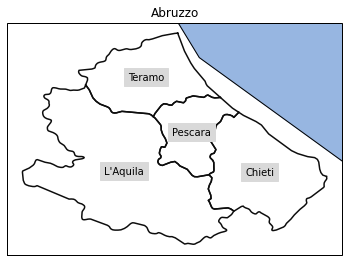

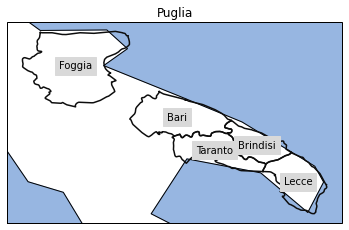

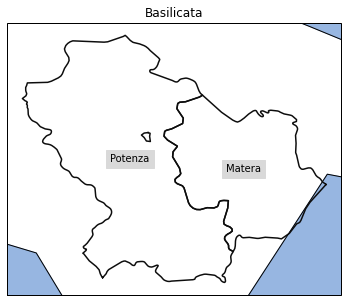

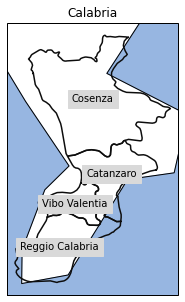

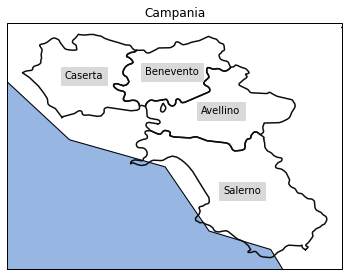

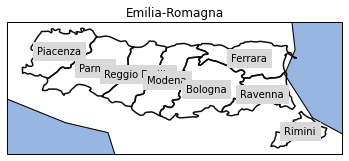

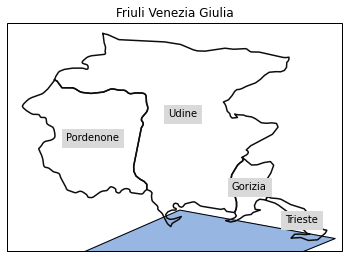

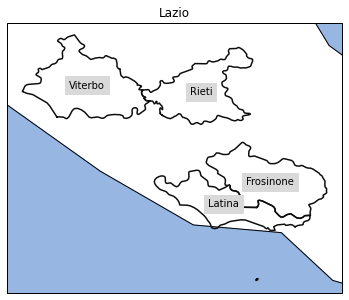

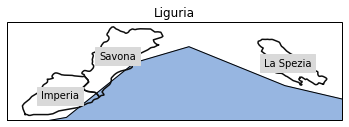

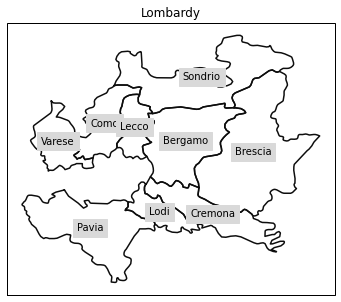

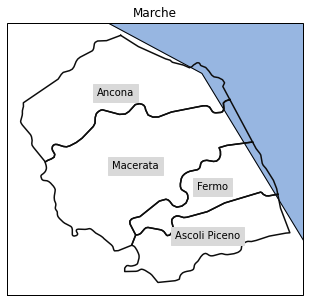

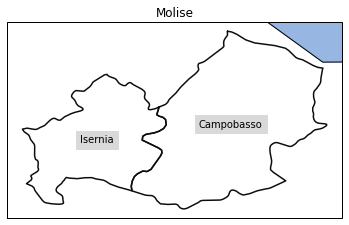

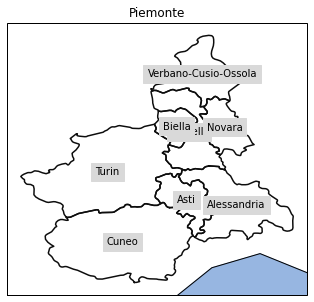

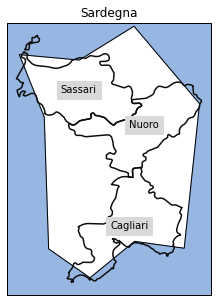

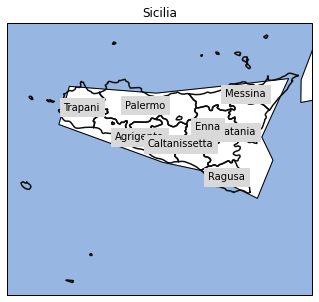

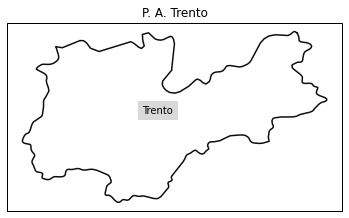

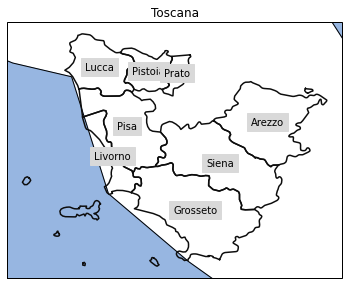

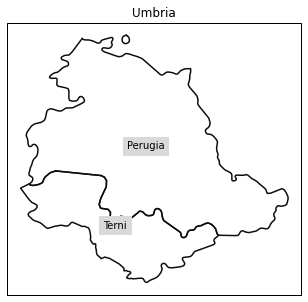

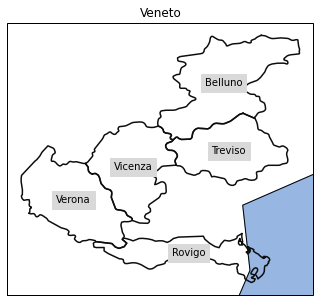

In [135]:
region_names = rdf['Administrative Region'].unique()
for region in region_names:
    tmp_province_names = rdf[rdf['Administrative Region'] == region]['Province'].unique()
    tmp_province_names = [province for province in all_provinces_names if province in tmp_province_names]
    tmp_provinces = all_provinces[tmp_province_names]
    if len(tmp_provinces) == 0:
        print(f"No provinces in {region}")
        continue
    plt.figure(figsize=(6,5))
    ax = tmp_provinces.plot(add_label=True, label='name');
    ax.set_title(region)

In [122]:

[province for province in all_province_names if 'Chieti' in province]

['Chieti']

## South Korea
Coming soon.

In [119]:
all_provinces.names

['Entre RÃ\xados',
 'PaysandÃº',
 'Sind',
 'Gujarat',
 'Kalimantan Timur',
 'Sabah',
 'Arica y Parinacota',
 'La Paz',
 'Oruro',
 'TarapacÃ¡',
 'PotosÃ\xad',
 'Antofagasta',
 'Tacna',
 'Salta',
 'Jujuy',
 'Dhekelia',
 'Jammu and Kashmir',
 'Xinjiang',
 'Xizang',
 'HaDarom',
 'Gaza Strip',
 'HaZafon',
 'West Bank',
 'Haifa',
 'HaMerkaz',
 'Jerusalem',
 'An Nabatiyah',
 'South Lebanon',
 'Southern Nations, Nationalities and Peoples',
 'Eastern Equatoria',
 'Somali',
 'Nugaal',
 'Mudug',
 'Galguduud',
 'Hiiraan',
 'Bakool',
 'Gedo',
 'Rift Valley',
 'Northern Areas',
 'Azad Kashmir',
 'Punjab',
 'Chitipa',
 'Mbeya',
 'Njombe',
 'Ruvuma',
 'Rumphi',
 'Nkhata Bay',
 'Arunachal Pradesh',
 'UNDOF',
 'Somaliland',
 'Bari',
 'Guyane franÃ§aise',
 'Sipaliwini',
 'Mahaica-Berbice',
 'Gangwon',
 'KangwÅ\x8fn-do',
 'Gyeonggi',
 'Hwanghae-bukto',
 'Guelmim - Es-Semara',
 'Western Sahara',
 'LaÃ¢youne - Boujdour - Sakia El Hamra',
 'Oued el Dahab',
 'Alajuela',
 'Rio San Juan',
 'LimÃ³n',
 'Heredia',